In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 3 - Fall 2021
## Due 5 Oct, 2021

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

For this assignment, download some [sample Ka data](http://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied.

In the file, the radar variables (such as reflectivity) are stored in arrays with dimension `(time, range)`. At each time, a single ray of data is collected, which extends along range. There is also a `sweep` dimension that corresponds to a few different variables. These variables mark the start and the end of each radar scan. Let's look at that structure:

In [3]:
#Path of the file
# Desktop/Datafields/Ka2140614021408.RAWPXA9.nc

d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')

print(d)

# Print the first ten elevation angles.
print(d.variables['elevation'][0:10])

# Shortcut to variable access
print(d.elevation[0:10])

<xarray.Dataset>
Dimensions:                    (time: 2938, range: 1666, sweep: 5)
Coordinates:
  * time                       (time) datetime64[ns] 2014-06-14T02:14:19 ... ...
  * range                      (range) float32 0.0 15.0 ... 2.496e+04 2.498e+04
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables: (12/25)
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    sweep_number               (sweep) int32 ...
    ...                         ...
    longitude                  float64 ...
    altitude                   float64 ...
    time_coverage_start        |S32 ...
    time_coverage_end          |S32 ...
    time_reference             |S32 ...
    

<xarray.DataArray 'sweep_mode' (sweep: 5)>
array([b'rhi', b'rhi', b'rhi', b'rhi', b'rhi'], dtype='|S32')
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)>
array([   0,  590, 1176, 1766, 2352], dtype=int32)
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)>
array([ 589, 1175, 1765, 2351, 2937], dtype=int32)
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count


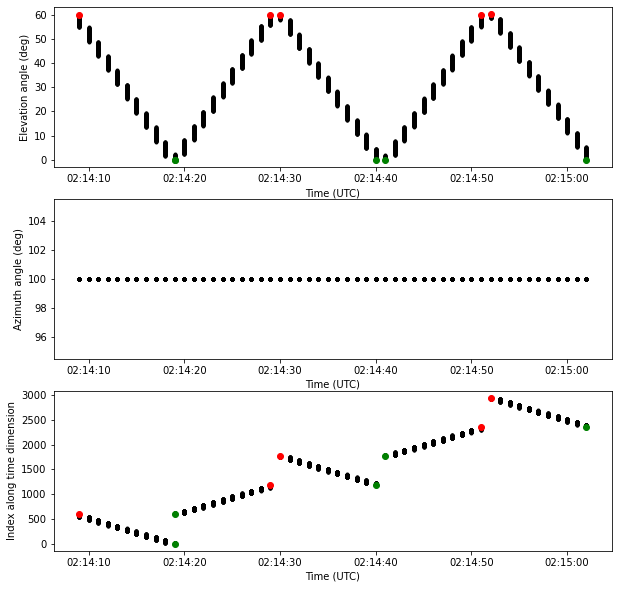

In [4]:
print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

The green dots mark the start of a sweep according to `sweep_start_ray_index`, and red marks the end according to `sweep_end_ray_index`. We observe that:

0. the scans are in [RHI](http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmod.rxml) mode, per the scan_mode variable.
1. the data have time precision of 1 s
2. the data are not stored in time order.
3. the data are stored in the file in order of increasing elevation angle, not increasing time.
4. azimuth angle is constant.

For the rest of this assignment, let's work with the second of the five scans, where time and elevation both increase with index along the time dimension. Reuse this variable instead of hard-coding a scan number in later code.

In [5]:
scan_idx = 1

**1.** Let's start by preparing the coordinates needed to plot a scan. Write a function that takes a radar dataset and scan index, and returns  1D arrays of ranges, azimuths, and elevations that correspond to the edges of each radar sample (a.k.a., each gate). Your function should return three separate 1d variables, as you see in the sample function call below. I found it helpful to visualize how the coordinates were distributed in 2D a quick, unlableled plot of each coordinate: `plt.imshow(r)`.

In [30]:
#Defining the start and the end to the sweeps using the scan_index
start_sweep = d.sweep_start_ray_index[scan_idx]
end_sweep = d.sweep_end_ray_index[scan_idx]
print('Completed Sweep')

#Creating a function to return 1D arrays of the range, azimuth, and elevation
def oned_arrays(d, scan_idx):
    ranges = np.array(d.range)
    azimuths = np.array(d.azimuth[start_sweep.values : end_sweep.values + 1])
    elevations = np.array(d.elevation[start_sweep.values : end_sweep.values + 1])
    return ranges, azimuths, elevations

r, az, el = oned_arrays(d, scan_idx)
print('Completed 1D Arrays')

#Creating a function that transforms data (currently in center points) to edge points
def centers_to_edges(x):
    nx_edges = x.shape[0] + 1
    xe = np.zeros(nx_edges)
    xe[1 : -1] = (x[1:] + x[:-1]) / 2.0
    xe[0] = x[0] - (x[1] - x[0]) / 2.0
    xe[-1] = x[-1] + (x[-1] - x[-2]) / 2.0
    return xe

r_edge = centers_to_edges(r)
e_edge = centers_to_edges(el)
print('Completed transforming centers to edges')


#Creating 2d arrays for two arrays: Range vs azimuth and range vs elevation
r_2d, el_2d = np.meshgrid(r_edge, e_edge)
az_2d = np.full_like(el_2d, az[0])

print('Completed creating 2D arrays')

Completed Sweep
Completed 1D Arrays
Completed transforming centers to edges
Completed creating 2D arrays


**2.** Make a 4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. Use `coordinateSystems.RadarCoordinateSystem` to plot in altitude above vs. range along a tangent plane. The tangent plane should be centered at the location of radar.

Note that if you find that the coordinate transformations fail to preserve the shape of your input coordinate arrays, you can fix it with `X.shape = r.shape`, where `X` has been transformed from `r`.

In [7]:
from coordinateSystems import RadarCoordinateSystem
from coordinateSystems import TangentPlaneCartesianSystem

#Defining the lat, lon, and alt values at the radar
ctrlat = d.latitude.values
ctrlon = d.longitude.values
ctralt = d.altitude.values


#Definging the tangent planes at the radar
radarcoord = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)
X_ECEF, Y_ECEF, Z_ECEF = radarcoord.toECEF(r_2d, az_2d, el_2d)

TPCS = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
X_TPCS, Y_TPCS, Z_TPCS = TPCS.fromECEF(X_ECEF, Y_ECEF, Z_ECEF)

print('Completed Defining Tangent Planes')

Completed Defining Tangent Planes


In [8]:
#Defining the arrays for the different variables taken by the radar within the sweep
reflectivity = d.reflectivity[start_sweep.values : end_sweep.values + 1]
velocity = np.array(d.velocity[start_sweep.values : end_sweep.values + 1])
spectrum_width = np.array(d.spectrum_width[start_sweep.values : end_sweep.values + 1])
normalized_coherent_power = np.array(d.normalized_coherent_power[start_sweep.values : end_sweep.values + 1])
print('Completed creating variable arrays')


#Making the shapes of the arrays the same so we can plot them
X_TPCS.shape = r_2d.shape
Y_TPCS.shape = r_2d.shape
Z_TPCS.shape = r_2d.shape

print('Shape of the X TPCS Array', X_TPCS.shape)
print('Shape of the Y TPCS Array', Y_TPCS.shape)
print('Shape of the Z TPCS Array', Z_TPCS.shape)
print('Shape of the Reflectivity Array', reflectivity.shape)
print('Shape of the Velocity Array', velocity.shape)
print('Shape of the Spectrum Width Array', spectrum_width.shape)
print('Shape of the Normalized Coherent Power Array', normalized_coherent_power.shape)

Completed creating variable arrays
Shape of the X TPCS Array (587, 1667)
Shape of the Y TPCS Array (587, 1667)
Shape of the Z TPCS Array (587, 1667)
Shape of the Reflectivity Array (586, 1666)
Shape of the Velocity Array (586, 1666)
Shape of the Spectrum Width Array (586, 1666)
Shape of the Normalized Coherent Power Array (586, 1666)


Completed importing NWS Colortables
Finished Plots


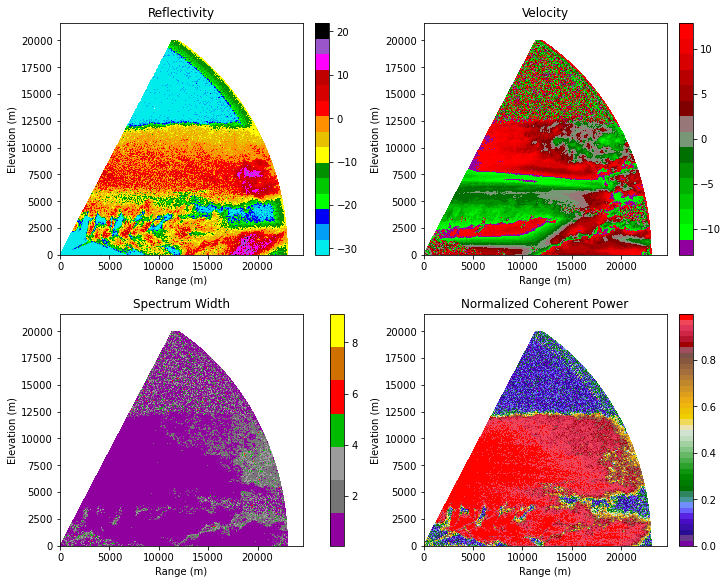

In [9]:
%matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import metpy


#Importing NWS color tables that will match them used by NWS
from metpy.plots import ctables
from matplotlib.colors import Normalize
NWSRef = ctables.registry.get_colortable('NWSReflectivity')
NWSVel = ctables.registry.get_colortable('NWSVelocity')
NWSSW = ctables.registry.get_colortable('NWSSpectrumWidth')
NWSNC = ctables.registry.get_colortable('Carbone42')
print('Completed importing NWS Colortables')

#Plotting the variables on the tangent plane
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,8), constrained_layout=True)

axes[0,0].plot
axes[0,0].set_xlabel('Range (m)')
axes[0,0].set_ylabel('Elevation (m)')
axes[0,0].set_title('Reflectivity')
im1 = axes[0,0].pcolormesh(X_TPCS, Z_TPCS, reflectivity, cmap=NWSRef, shading='auto')
plt.colorbar(im1, ax=axes[0,0])

axes[0,1].plot
axes[0,1].set_xlabel('Range (m)')
axes[0,1].set_ylabel('Elevation (m)')
axes[0,1].set_title('Velocity')
im2 = axes[0,1].pcolormesh(X_TPCS, Z_TPCS, velocity, cmap=NWSVel, shading='auto')
plt.colorbar(im2, ax=axes[0,1])

axes[1,0].plot
axes[1,0].set_xlabel('Range (m)')
axes[1,0].set_ylabel('Elevation (m)')
axes[1,0].set_title('Spectrum Width')
im3 = axes[1,0].pcolormesh(X_TPCS, Z_TPCS, spectrum_width, cmap=NWSSW, shading='auto')
plt.colorbar(im3, ax=axes[1,0])

axes[1,1].plot
axes[1,1].set_xlabel('Range (m)')
axes[1,1].set_ylabel('Elevation (m)')
axes[1,1].set_title('Normalized Coherent Power')
im4 = axes[1,1].pcolormesh(X_TPCS, Z_TPCS, normalized_coherent_power, cmap=NWSNC, shading='auto')
plt.colorbar(im4, ax=axes[1,1])

print('Finished Plots')

**3.** Repeat the plot for question 2, but for an aziuthal equidistant map projection centered at the radar location.

In [10]:
# Where is the radar? What is its gate spacing?
print(d.latitude)
print(d.longitude)
print(d.range[1]-d.range[0])

<xarray.DataArray 'latitude' ()>
array(34.72259)
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  Latitude
<xarray.DataArray 'longitude' ()>
array(-76.74685)
Attributes:
    long_name:      Longitude
    units:          degrees_east
    standard_name:  Longitude
<xarray.DataArray 'range' ()>
array(15., dtype=float32)


Shape of the X AEQD Array (587, 1667)
Shape of the Y AEQD Array (587, 1667)
Shape of the Z AEQD Array (587, 1667)
Finished arrays
Finished Plots


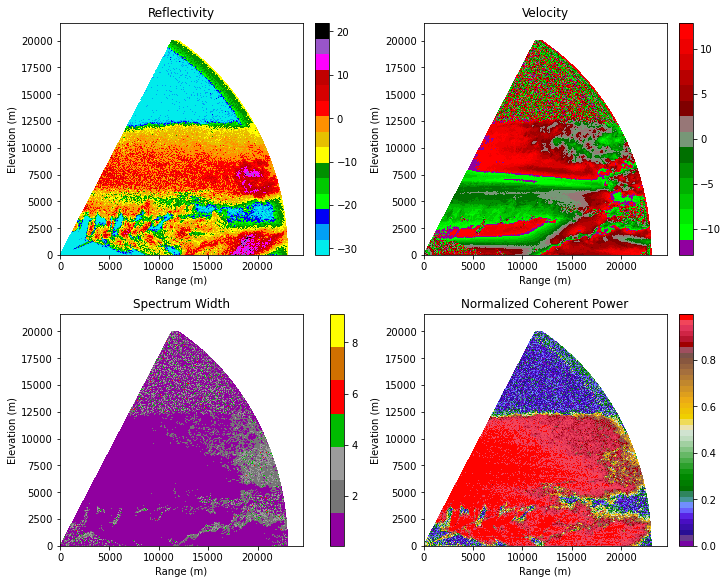

In [11]:
#Importing the projection to use for the new projection planes and then defining the planes
from coordinateSystems import MapProjection
aeqd = MapProjection(projection='aeqd', lon_0=ctrlon, lat_0=ctrlat)
X_AEQD, Y_AEQD, Z_AEQD = aeqd.fromECEF(X_ECEF, Y_ECEF, Z_ECEF)


#Making the planes have the same shapes
X_AEQD.shape = r_2d.shape
Y_AEQD.shape = r_2d.shape
Z_AEQD.shape = r_2d.shape

print('Shape of the X AEQD Array', X_AEQD.shape)
print('Shape of the Y AEQD Array', Y_AEQD.shape)
print('Shape of the Z AEQD Array', Z_AEQD.shape)
print('Finished arrays')


#Plotting the vaiables with a aziuthal equidistant map projection
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,8), constrained_layout=True)

axes[0,0].plot
axes[0,0].set_xlabel('Range (m)')
axes[0,0].set_ylabel('Elevation (m)')
axes[0,0].set_title('Reflectivity')
im1 = axes[0,0].pcolormesh(X_AEQD, Z_AEQD, reflectivity, cmap=NWSRef)
plt.colorbar(im1, ax=axes[0,0])

axes[0,1].plot
axes[0,1].set_xlabel('Range (m)')
axes[0,1].set_ylabel('Elevation (m)')
axes[0,1].set_title('Velocity')
im2 = axes[0,1].pcolormesh(X_AEQD, Z_AEQD, velocity, cmap=NWSVel)
plt.colorbar(im2, ax=axes[0,1])

axes[1,0].plot
axes[1,0].set_xlabel('Range (m)')
axes[1,0].set_ylabel('Elevation (m)')
axes[1,0].set_title('Spectrum Width')
im3 = axes[1,0].pcolormesh(X_AEQD, Z_AEQD, spectrum_width, cmap=NWSSW)
plt.colorbar(im3, ax=axes[1,0])

axes[1,1].plot
axes[1,1].set_xlabel('Range (m)')
axes[1,1].set_ylabel('Elevation (m)')
axes[1,1].set_title('Normalized Coherent Power')
im4 = axes[1,1].pcolormesh(X_AEQD, Z_AEQD, normalized_coherent_power, cmap=NWSNC)
plt.colorbar(im4, ax=axes[1,1])

print('Finished Plots')

To set the stage for the next two assignments, let's say we want to oversample the 15 m range gates to a 5 m carteisian grid in the domain 9.0…9.5 km range and 2.9…3.4 km altitude. Once again, we will use the distance above and the range along the tangent plane.

**4.** Create 2D arrays giving the corresponding center locations for each desired analysis location. Start with 1D grid box edges spanning the range above.

In [21]:
#Creating the range array
inc = 5
range_arr_start = 9000
range_arr_end = 9500
range_arr = np.arange(range_arr_start, range_arr_end + inc, inc)
print('Finished creating range array')


#Creating the altitude array
alt_arr_start = 2900
alt_arr_end = 3400
alt_arr = np.arange(alt_arr_start, alt_arr_end + inc, inc)
print('Finished creating altitude array')


#Defining function to transform data edges to centers
def edges_to_centers_1d(x):
    dis = 2.5
    return np.arange(min(x) + dis, max(x) - dis/2, 2*dis)

range_arr_centers = edges_to_centers_1d(range_arr)
alt_arr_centers = edges_to_centers_1d(alt_arr)
print('Finished transforming edges to centers')


#Defining function to mesh arrays together to 2D array
def coords_2d_array(range_arr_centers, alt_arr_centers):
    range_2d, alt_2d = np.meshgrid(range_arr_centers, alt_arr_centers)
    return range_2d, alt_2d

range_2darray, alt_2darray = coords_2d_array(range_arr_centers, alt_arr_centers)
print('Finished creating 2D arrays')

Finished creating range array
Finished creating altitude array
Finished transforming edges to centers
Finished creating 2D arrays


**5.** For the next question, we will interpolate in three ways:
- nearest neighbor
- linear
- the traditional meteorological "Barnes" analysis (which is really a Gaussian blur fliter). 

To do so, we will use MetPy's built-in interpolators. It wraps SciPy's built-in nearest and linear interpolation methods, and adds Barnes, natural neighbor, and other interpolators. 

You will probably need to install metpy with `conda install -c conda-forge metpy`.

Once you have installed MetPy, use its `interpolate_to_points` function. Note that it takes three arguments, and those arguments require that you use `np.vstack` to rearrange the locations and data into the correct shape.

So that the Barnes analysis doesn't take forever, you will want to subset the data to only those locations that overlap with the analysis grid.

In [25]:
# from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, griddata
# from metpy.units import units
from metpy.interpolate import interpolate_to_points

In [22]:
#Creating 2D arrays of the center points
r_ctr_2d, el_ctr_2d = np.meshgrid(r, el)
az_ctr_2d = np.full_like(el_ctr_2d, az[0])

#Definging the tangent planes at the radar, TPCS, and AEQD
X_ctr_ECEF, Y_ctr_ECEF, Z_ctr_ECEF = radarcoord.toECEF(r_ctr_2d, az_ctr_2d, el_ctr_2d)

X_ctr_TPCS, Y_ctr_TPCS, Z_ctr_TPCS = TPCS.fromECEF(X_ctr_ECEF, Y_ctr_ECEF, Z_ctr_ECEF)

X_ctr_AEQD, Y_ctr_AEQD, Z_ctr_AEQD = aeqd.fromECEF(X_ctr_ECEF, Y_ctr_ECEF, Z_ctr_ECEF)

In [26]:
#Creating the array of the coordinates of the data points
X_flat = X_ctr_AEQD.flatten()
Z_flat = Z_ctr_AEQD.flatten()
points_stacked = np.vstack((X_flat, Z_flat))
points = np.transpose(points_stacked)


#Creating the array of the values of the data points
values_reflectivity = np.hstack(reflectivity)
values_velocity = np.hstack(velocity)
values_spectrum_width = np.hstack(spectrum_width)
values_normalized_coherent_power = np.hstack(normalized_coherent_power)

print('Finished creating arrays')


#Creating a subset for the Barnes analysis
subset_func = np.logical_and(np.logical_and(X_ctr_AEQD >= range_arr_start, X_ctr_AEQD <= range_arr_end), np.logical_and(Z_ctr_AEQD >= alt_arr_start, Z_ctr_AEQD<= alt_arr_end))
x_subset = X_flat[subset_func]
z_subset = Z_flat[subset_func]
ref_subset = values_reflectivity[subset_func]
vel_subset = values_velocity[subset_func]
sw_subset = values_spectrum_width[subset_func]
ncp_subset = values_normalized_coherent_power[subset_func]
subset_stacked = np.vstack((x_subset, z_subset))
subset_t = np.transpose(subset_stacked)

range_flat = range_2darray.flatten()
alt_flat = alt_2darray.flatten()
xi_stacked = np.vstack((range_flat, alt_flat))
xi_barnes = np.transpose(xi_stacked)

print('Finished creating subset')


#Creating interpolation arrays
#Nearest Neighbor Arrays
nearest_reflectivity = interpolate_to_points(points, values_reflectivity, (range_2darray, alt_2darray), interp_type='nearest')
nearest_velocity = interpolate_to_points(points, values_velocity, (range_2darray, alt_2darray), interp_type='nearest')
nearest_sw = interpolate_to_points(points, values_spectrum_width, (range_2darray, alt_2darray), interp_type='nearest')
nearest_ncp = interpolate_to_points(points, values_normalized_coherent_power, (range_2darray, alt_2darray), 
                                    interp_type='nearest')
print('Finished Nearest Neighbor interpolation')

#Creating linear Arrays
linear_reflectivity = interpolate_to_points(points, values_reflectivity, (range_2darray, alt_2darray), interp_type='linear')
linear_velocity = interpolate_to_points(points, values_velocity, (range_2darray, alt_2darray), interp_type='linear')
linear_sw = interpolate_to_points(points, values_spectrum_width, (range_2darray, alt_2darray), interp_type='linear')
linear_ncp = interpolate_to_points(points, values_normalized_coherent_power, (range_2darray, alt_2darray), interp_type='linear')

print('Finished linear interpolation')


#Barnes analysis
barnes_reflectivity = interpolate_to_points(subset_t, ref_subset, xi_barnes, interp_type='barnes')
barnes_velocity = interpolate_to_points(subset_t, vel_subset, xi_barnes, interp_type='barnes')
barnes_sw = interpolate_to_points(subset_t, sw_subset, xi_barnes, interp_type='barnes')
barnes_ncp = interpolate_to_points(subset_t, ncp_subset, xi_barnes, interp_type='barnes')

barnes_reflectivity.shape = range_2darray.shape
barnes_velocity.shape = range_2darray.shape
barnes_sw.shape = range_2darray.shape
barnes_ncp.shape = range_2darray.shape

print('Finished Barnes interpolation')

Finished creating arrays
Finished creating subset
Finished Nearest Neighbor interpolation
Finished linear interpolation
Finished Barnes interpolation


**6.** Make a plot of the original data and the three interpolation methods. Compared to the original data, what do the three interpolation methods do to the data? Think about what you would regard as desirable properties of an analysis.

Finished Reflectivity Plots
Finished Velocity Plots
Finished Spectrum Width Plots
Finished Normalized Coherent Power Plots


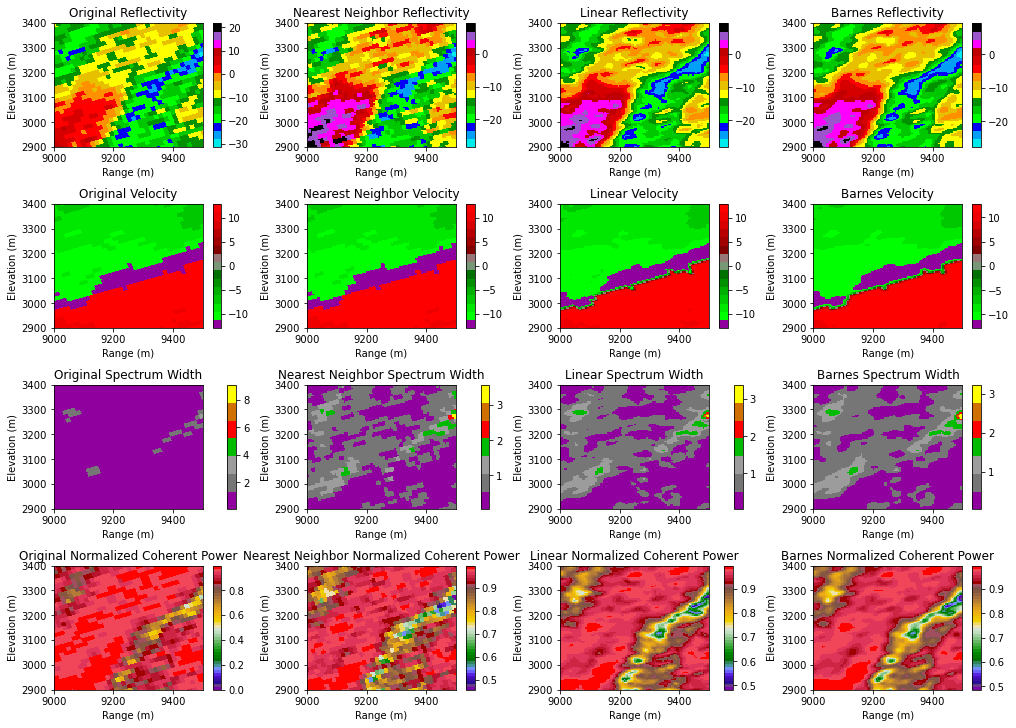

In [27]:
n_rows, n_cols = 4, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,10), constrained_layout=True)

#Plotting Reflectivity
axes[0,0].plot
axes[0,0].set_xlabel('Range (m)')
axes[0,0].set_ylabel('Elevation (m)')
axes[0,0].set_title('Original Reflectivity')
axes[0,0].set_xlim([range_arr_start,range_arr_end])
axes[0,0].set_ylim([alt_arr_start,alt_arr_end])
im00 = axes[0,0].pcolormesh(X_AEQD, Z_AEQD, reflectivity, cmap=NWSRef)
plt.colorbar(im00, ax=axes[0,0])

axes[0,1].plot
axes[0,1].set_xlabel('Range (m)')
axes[0,1].set_ylabel('Elevation (m)')
axes[0,1].set_title('Nearest Neighbor Reflectivity')
im01 = axes[0,1].pcolormesh(range_arr, alt_arr, nearest_reflectivity, cmap=NWSRef)
plt.colorbar(im01, ax=axes[0,1])

axes[0,2].plot
axes[0,2].set_xlabel('Range (m)')
axes[0,2].set_ylabel('Elevation (m)')
axes[0,2].set_title('Linear Reflectivity')
im02 = axes[0,2].pcolormesh(range_arr, alt_arr, linear_reflectivity, cmap=NWSRef)
plt.colorbar(im02, ax=axes[0,2])

axes[0,3].plot
axes[0,3].set_xlabel('Range (m)')
axes[0,3].set_ylabel('Elevation (m)')
axes[0,3].set_title('Barnes Reflectivity')
im03 = axes[0,3].pcolormesh(range_arr, alt_arr, barnes_reflectivity, cmap=NWSRef)
plt.colorbar(im03, ax=axes[0,3])

print('Finished Reflectivity Plots')


#Plotting velocity
axes[1,0].plot
axes[1,0].set_xlabel('Range (m)')
axes[1,0].set_ylabel('Elevation (m)')
axes[1,0].set_title('Original Velocity')
axes[1,0].set_xlim([range_arr_start,range_arr_end])
axes[1,0].set_ylim([alt_arr_start,alt_arr_end])
im10 = axes[1,0].pcolormesh(X_AEQD, Z_AEQD, velocity, cmap=NWSVel)
plt.colorbar(im10, ax=axes[1,0])

axes[1,1].plot
axes[1,1].set_xlabel('Range (m)')
axes[1,1].set_ylabel('Elevation (m)')
axes[1,1].set_title('Nearest Neighbor Velocity')
im11 = axes[1,1].pcolormesh(range_arr, alt_arr, nearest_velocity, cmap=NWSVel)
plt.colorbar(im11, ax=axes[1,1])

axes[1,2].plot
axes[1,2].set_xlabel('Range (m)')
axes[1,2].set_ylabel('Elevation (m)')
axes[1,2].set_title('Linear Velocity')
im12 = axes[1,2].pcolormesh(range_arr, alt_arr, linear_velocity, cmap=NWSVel)
plt.colorbar(im12, ax=axes[1,2])

axes[1,3].plot
axes[1,3].set_xlabel('Range (m)')
axes[1,3].set_ylabel('Elevation (m)')
axes[1,3].set_title('Barnes Velocity')
im13 = axes[1,3].pcolormesh(range_arr, alt_arr, barnes_velocity, cmap=NWSVel)
plt.colorbar(im13, ax=axes[1,3])

print('Finished Velocity Plots')


#Plotting Spectrum Width
axes[2,0].plot
axes[2,0].set_xlabel('Range (m)')
axes[2,0].set_ylabel('Elevation (m)')
axes[2,0].set_title('Original Spectrum Width')
axes[2,0].set_xlim([range_arr_start,range_arr_end])
axes[2,0].set_ylim([alt_arr_start,alt_arr_end])
im20 = axes[2,0].pcolormesh(X_AEQD, Z_AEQD, spectrum_width, cmap=NWSSW)
plt.colorbar(im20, ax=axes[2,0])

axes[2,1].plot
axes[2,1].set_xlabel('Range (m)')
axes[2,1].set_ylabel('Elevation (m)')
axes[2,1].set_title('Nearest Neighbor Spectrum Width')
im21 = axes[2,1].pcolormesh(range_arr, alt_arr, nearest_sw, cmap=NWSSW)
plt.colorbar(im21, ax=axes[2,1])

axes[2,2].plot
axes[2,2].set_xlabel('Range (m)')
axes[2,2].set_ylabel('Elevation (m)')
axes[2,2].set_title('Linear Spectrum Width')
im22 = axes[2,2].pcolormesh(range_arr, alt_arr, linear_sw, cmap=NWSSW)
plt.colorbar(im22, ax=axes[2,2])

axes[2,3].plot
axes[2,3].set_xlabel('Range (m)')
axes[2,3].set_ylabel('Elevation (m)')
axes[2,3].set_title('Barnes Spectrum Width')
im23 = axes[2,3].pcolormesh(range_arr, alt_arr, barnes_sw, cmap=NWSSW)
plt.colorbar(im23, ax=axes[2,3])

print('Finished Spectrum Width Plots')


#Plotting Normalized Coherent Power
axes[3,0].plot
axes[3,0].set_xlabel('Range (m)')
axes[3,0].set_ylabel('Elevation (m)')
axes[3,0].set_title('Original Normalized Coherent Power')
axes[3,0].set_xlim([range_arr_start,range_arr_end])
axes[3,0].set_ylim([alt_arr_start,alt_arr_end])
im30 = axes[3,0].pcolormesh(X_AEQD, Z_AEQD, normalized_coherent_power, cmap=NWSNC)
plt.colorbar(im30, ax=axes[3,0])

axes[3,1].plot
axes[3,1].set_xlabel('Range (m)')
axes[3,1].set_ylabel('Elevation (m)')
axes[3,1].set_title('Nearest Neighbor Normalized Coherent Power')
im31 = axes[3,1].pcolormesh(range_arr, alt_arr, nearest_ncp, cmap=NWSNC)
plt.colorbar(im31, ax=axes[3,1])

axes[3,2].plot
axes[3,2].set_xlabel('Range (m)')
axes[3,2].set_ylabel('Elevation (m)')
axes[3,2].set_title('Linear Normalized Coherent Power')
im32 = axes[3,2].pcolormesh(range_arr, alt_arr, linear_ncp, cmap=NWSNC)
plt.colorbar(im32, ax=axes[3,2])

axes[3,3].plot
axes[3,3].set_xlabel('Range (m)')
axes[3,3].set_ylabel('Elevation (m)')
axes[3,3].set_title('Barnes Normalized Coherent Power')
im33 = axes[3,3].pcolormesh(range_arr, alt_arr, barnes_ncp, cmap=NWSNC)
plt.colorbar(im33, ax=axes[3,3])

print('Finished Normalized Coherent Power Plots')

Starting with the definitions of each type of interpolation method

Nearest neighbor: the nearest neighbor is the most simple method of interpolation out of the three. It simply takes each point and assuming its value based on the next closest point, no matter the weight of the other. If one is wishing for a quick simple method, this is good, and is showing smaller scale features when compared to the original data, but it is still pixalated and a bit hard to read. In contrast, this method is nice as one can keep the origninal values without too much alteration. 

Linear: fitting the best curve with linear polynomials to best find the new points. This is also a very simple interpolation method, and is very quick and easy. But it also can still be not very precise. 

Barnes: this method uses the distance and distribution between two points to determine how much a point should be weighted when interpolating the data. This is good as it can distribute irregularly spaced points, but is the most challenging out of the three methods. 